# Cleaning and Preprocessing Variables

This notebook describes how variables were cleaned for data processing. The output files of this script will go in the clean_data/ folder.

In [2]:
# Importing libraries
import os
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import re

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Cleaning Non-Energy Variables

## American Community Survey (ACS), US Census

In [ ]:
acs = pd.read_csv("data/acs/acs_data.csv", dtype = {
   "STATE": str,
   "GEOID": str
})

# Removing unnecessary variables
acs.pop("NAME")
acs.pop("state")
acs.pop("county")
acs.pop("tract")

# Estimate for percent BIPOC
acs["bipoc_percent"] = (acs["white_no_hispanic"] / acs["total_pop"]) * 100
acs["bipoc_percent"] = 100 - acs["bipoc_percent"]
acs.pop("white_no_hispanic")

# Turn appropriate variables from raw counts to percentages
acs["internet_access"] = (acs["internet_access"] / acs["total_households"]) * 100
acs["no_hs"] = (acs["less_than_hs"] / acs["total_pop"]) * 100
acs.pop("less_than_hs")
acs["insured"] = (acs["insured"] / acs["total_pop"]) * 100
acs["senior_living_alone"] = (acs["senior_living_alone"] / acs["total_households"]) * 100
acs["owner_occupied"] = (acs["owner_occupied"] / acs["occupied_housing_units"]) * 100
acs["renter_occupied"] = (acs["renter_occupied"] / acs["occupied_housing_units"]) * 100
acs.pop("occupied_housing_units")
acs["disabled"] = (acs["disabled"] / acs["pop_16_plus"]) * 100
acs.pop("pop_16_plus")

acs_num_cols = [
   "total_pop",
   "year_built",
   "internet_access",
   "total_households",
   "labor_force_rate",
   "insured",
   "senior_living_alone",
   "median_income",
   "owner_occupied",
   "renter_occupied",
   "disabled",
   "bipoc_percent",
   "no_hs"
]

for col in acs_num_cols:
   acs[col] = np.where(
      acs[col] < 0,
      np.nan,
      acs[col]
   )

acs.to_csv("clean_data/non_energy/acs.csv", index = False)
acs.dtypes

## Climate Vulnerability

In [ ]:
# Read climate vulnerability with correct column types
climate_vulnerability = pd.read_csv(
   "data/climate_vulnerability/NRI_Table_CensusTracts/NRI_Table_CensusTracts.csv",
   dtype = {
      "TRACTFIPS": str,
      "HRCN_RISKS": float, 
      "HRCN_RISKR": str,
      "HWAV_RISKS": float,
      "HWAV_RISKR": str,
      "WFIR_RISKS": float,
      "WFIR_RISKR": str
      }
   )

# Subset and Rename column names
climate_vulnerability = climate_vulnerability[[
   "TRACTFIPS",
   "HRCN_RISKS",
   "HRCN_RISKR",
   "HWAV_RISKS",
   "HWAV_RISKR",
   "WFIR_RISKS",
   "WFIR_RISKR"]]

climate_vulnerability.columns = [
   "GEOID",
   "hurricane_risk_index",
   "hurricane_risk_rating",
   "heat_wave_risk_index",
   "heat_wave_risk_rating",
   "wild_fire_risk_index",
   "wild_fire_risk_rating"
   ]

# Format GEOID column to have 11 digits, pad with 0s as necessary
climate_vulnerability["GEOID"] = np.where(
   climate_vulnerability["GEOID"].str.len() == 10,
   "0" + climate_vulnerability["GEOID"],
   climate_vulnerability["GEOID"]
)

# Write results out
climate_vulnerability.to_csv("clean_data/non_energy/climate_vulnerability.csv", index = False)
climate_vulnerability.head()

## Social Vulnerability

In [ ]:
# Read in social vulnerability
social_vulnerability = pd.read_csv("data/social_vulnerability/SVI2018_US.csv", dtype = {"FIPS": str, "F_TOTAL": float})

# Subset and Rename columns
social_vulnerability = social_vulnerability[["FIPS", "EP_MOBILE", "EP_SNGPNT"]]
social_vulnerability.columns = ["GEOID", "mobile_homes", "single_parent_households"]

# Format GEOID column to have 11 digits, pad with 0s as necessary
social_vulnerability["GEOID"] = np.where(
   social_vulnerability["GEOID"].str.len() == 10,
   "0" + social_vulnerability["GEOID"],
   social_vulnerability["GEOID"]
)

social_vulnerability.to_csv("clean_data/non_energy/social_vulnerability.csv", index = False)
social_vulnerability.head()

## Eviction Data by County

In [ ]:
eviction = pd.read_csv(
   "data/eviction/county_proprietary_valid_2000_2018.csv",
   dtype = {
      "cofips": str,
      "year": int,
      "filing_rate": float
   }
   )
eviction = eviction[["cofips", "year", "filing_rate"]]
eviction_final = eviction.groupby(["cofips"], as_index = False).max("year")
# Test if there is 1 value for each county
#eviction_final[["cofips", "year"]].groupby(["cofips"], as_index = False).nunique()["year"].unique()

# Subset and Rename columns accordingly
eviction_final = eviction_final[["cofips", "filing_rate"]]
eviction_final.columns = ["county_GEOID", "filing_rate"]

# Format county GEOID properly - fill in zeros accordingly
eviction_final["county_GEOID"] = np.where(
   eviction_final["county_GEOID"].str.len() == 4,
   "0" + eviction_final["county_GEOID"],
   eviction_final["county_GEOID"]
)

# Split county_GEOID into STATEFP and COUNTYFP for overall join at the end
eviction_final["STATEFP"] = eviction_final["county_GEOID"].str[:2]
eviction_final["COUNTYFP"] = eviction_final["county_GEOID"].str[2:]
eviction_final.pop("county_GEOID")

# Write out
eviction_final.to_csv("clean_data/non_energy/eviction.csv", index = False)
eviction_final.head()

# Cleaning Energy Variables

In [ ]:
# File and Directory setup
energy_dir = "data/energy"

e_burden_dir = "data/energy/doe_lead"
e_burden_outdir = "clean_data/energy/doe_lead"

aceee_outdir = "clean_data/energy"

## Energy Burden

Subsequent code blocks take the energy burden files downloaded from the DOE LEAD tool remove unnecesarily rows and compile them together into one CSV file.

In [ ]:
e_burden_files = os.listdir(e_burden_dir)

# Remove any unwanted files
e_burden_files = [filename for filename in e_burden_files if re.match(r"(?:[A-Z])(?:[A-Z])\.csv", filename)]

In [ ]:
# Re-write Energy Burden files
for e_burden_filename in e_burden_files:
   # Read in current file
   curr_fp = os.path.join(e_burden_dir, e_burden_filename)
   f = open(curr_fp, "r")
   lines = f.readlines()
   f.close()

   # Remove rows of DOE LEAD Energy burden files (metadata, description)
   lines = lines[8:]

   # Write file back without description rows
   out_fp = os.path.join(e_burden_outdir, e_burden_filename)
   f_out = open(out_fp, "w")
   f_out.writelines(lines)
   f_out.close()


In [ ]:

# Compile all Energy Burden files together

# Energy Burden dataframe (collector)
e_burden = pd.DataFrame(data = None, columns = ["GEOID", "energy_burden"])

for e_burden_filename in e_burden_files:
   curr_fp = os.path.join(e_burden_outdir, e_burden_filename)
   curr_df = pd.read_csv(curr_fp, dtype={"Geography ID": str})

   # Format current dataframe
   curr_df = curr_df[["Geography ID", "Avg. Energy Burden (% income)"]]
   curr_df.columns = ["GEOID", "energy_burden"]
   curr_df["GEOID"] = np.where(
      curr_df["GEOID"].str.len() == 10,
      '0' + curr_df["GEOID"],
      curr_df["GEOID"]
   )

   # Collect current 
   e_burden = pd.concat([e_burden, curr_df])

e_burden["energy_burden"] = np.where(
   e_burden["energy_burden"] > 100.0,
   100.0,
   e_burden["energy_burden"]
)

# Writing Energy burden dataframe
e_burden.to_csv(os.path.join("clean_data/energy", "energy_burden.csv"), index = False)



## ACEEE State Scorecard Variables

**Note:** ACEEE State Scorecard Variables are reported at a state level, and so each the state level score was broadcasted and assigned to be the score for each census tract of their respective state.

In [ ]:
aceee = pd.read_csv(os.path.join(energy_dir, "ACEEE State Scorecard Data, 2021.csv"))

# Capturing correct columns
aceee = aceee[[
   "STATE",
   "GAS \nSAVINGS - % \nof retail residential and commercial sales",
   "ELECTRIC SAVINGS - % \nof retail sales"
   ]]
aceee.columns = ["STATE", "gas_savings_percent", "electric_savings_percent"]

# Getting rid of excess empty rows
aceee = aceee.iloc[2:53]

# Add their state fips code
state_fips = pd.read_csv("data/support/state_fips.csv", dtype = {"STATE": str})
state_fips = state_fips[["STATE_NAME", "STATE"]]
state_fips.columns = ["STATE", "STATEFP"]
aceee = pd.merge(aceee, state_fips, how = "left", on = "STATE")

# Remove $ and % signs
aceee["gas_savings_percent"] = aceee["gas_savings_percent"].str[:-1]
aceee["electric_savings_percent"] = aceee["electric_savings_percent"].str[:-1]

# Make sure all columns are correct types
aceee = aceee.astype({
   "STATE": str,
   "STATEFP": str,
   "gas_savings_percent": float,
   "electric_savings_percent": float
})

# Write ACEEE data
aceee.to_csv(os.path.join(aceee_outdir, "aceee.csv"), index = False)
aceee.head()

## Home Energy Affordability Gap

In [ ]:
e_affordability = pd.read_csv("data/energy/Home Energy Affordability Gap by county (2021).csv")

# Get average shortfall / LI HH for households below 200% of FPL
e_affordability = e_affordability.iloc[2:3145, [2, 95]]
e_affordability.columns = ["county_GEOID", "avg_shortfall_usd"]


# Process columns
e_affordability = e_affordability.astype({
   "county_GEOID": str,
   "avg_shortfall_usd": str
})
# Fill county_geoid (= statefp + countyfp) with zeros if necessary
e_affordability["county_GEOID"] = np.where(
   e_affordability["county_GEOID"].str.len() == 4,
   "0" + e_affordability["county_GEOID"],
   e_affordability["county_GEOID"]
)

# Format avg_shortfall_usd from str format to float
e_affordability["avg_shortfall_usd"] = e_affordability["avg_shortfall_usd"].str[1:]
e_affordability["avg_shortfall_usd"] = e_affordability["avg_shortfall_usd"].str.replace(",", "", regex = False)
e_affordability["avg_shortfall_usd"] = e_affordability["avg_shortfall_usd"].str.replace("DIV/0!", "NaN", regex = False)
e_affordability = e_affordability.astype({"avg_shortfall_usd": float})
e_affordability = e_affordability.fillna(-999)

# Split county_GEOID into STATEFP and COUNTYFP for overall join at the end
e_affordability["STATEFP"] = e_affordability["county_GEOID"].str[:2]
e_affordability["COUNTYFP"] = e_affordability["county_GEOID"].str[2:]
e_affordability.pop("county_GEOID")

# Write out
e_affordability.to_csv("clean_data/energy/home_energy_affordability_gap.csv", index = False)
e_affordability.head()

## Community Power Scorecard

In [ ]:
community_power = pd.read_csv("data/energy/Community Power Scorecard & Methodology (2022).csv")
community_power = community_power.iloc[:51, [1, 14]]
community_power.columns = ["STATE", "total_percent_score"]

# Renaming Washington DC for STATEFP join
community_power["STATE"] = np.where(
   community_power["STATE"].str[:] == "Washington D.C.",
   "District of Columbia",
   community_power["STATE"]
)

# Add their state fips code
state_fips = pd.read_csv("data/support/state_fips.csv", dtype = {"STATE": str})
state_fips = state_fips[["STATE_NAME", "STATE"]]
state_fips.columns = ["STATE", "STATEFP"]
community_power = pd.merge(community_power, state_fips, how = "left", on = "STATE")

community_power.to_csv("clean_data/energy/community_power_scorecard.csv", index = False)
community_power

## Median income of solar installers by tract

In [ ]:
solar_installers = pd.read_csv("data/energy/Median income of solar installers by tract.csv", dtype = {"CensusTract": str, "n": int, "median_income": float})
solar_installers.columns = ["GEOID", "num_solar_installers", "median_income_solar"]

# Make sure all tract numbers are 11 digits long pad with zeros accordingly
solar_installers["GEOID"] = np.where(
   solar_installers["GEOID"].str.len() == 10,
   "0" + solar_installers["GEOID"],
   solar_installers["GEOID"]
)

# Write file out
solar_installers.to_csv("clean_data/energy/median_income_solar_installer.csv", index = False)
solar_installers.head()


## Residential Rates as a % of Commercial and Industral rates

In [ ]:
res_percent = pd.read_csv("data/energy/Residential cost per kWh as % of commercial + industrial rates.csv")
# Keep relevant columns and rows
res_percent = res_percent.iloc[3:54, [0, 8]]
# Rename columns
res_percent.columns = ["STATE", "res_rate_percent_commercial_industrial"]
# Make sure column types are correct
res_percent = res_percent.astype({
   "STATE": str,
   "res_rate_percent_commercial_industrial": str
})

# Remove % sign from residential rates and cast as float
res_percent["res_rate_percent_commercial_industrial"] = res_percent["res_rate_percent_commercial_industrial"].str[:-1]
res_percent = res_percent.astype({"res_rate_percent_commercial_industrial": float})

# Add their state fips code
state_fips = pd.read_csv("data/support/state_fips.csv", dtype = {"STATE": str})
state_fips = state_fips[["STATE_NAME", "STATE"]]
state_fips.columns = ["STATE", "STATEFP"]
res_percent = pd.merge(res_percent, state_fips, how = "left", on = "STATE")

# Write results out
res_percent.to_csv("clean_data/energy/res_rate_percent_commercial_industrial.csv", index = False)
res_percent.head()

# Combine all variables into one output file

In [3]:
# Use census tract metadata file as base dataframe for joins
# Taken from: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
eep = gpd.read_file("data/geography/cb_2021_us_tract_500k.zip", dtype = {
   "STATEFP": str,
   "COUNTYFP": str,
   "TRACTCE": str,
   "GEOID": str
})

unwanted_states = [
	"60", # American Samoa
  "66", # Guam
  "69", # Northern Mariana Islands
  "72", # Puerto Rico
  "78", # Virgin Islands
  "15", # Hawaii
  "02",  # Alaska
]

eep = eep[~eep.STATEFP.isin(unwanted_states)]


In [4]:
# Tables containing variables that will be joined
energy_burden = pd.read_csv("clean_data/energy/energy_burden.csv", dtype = {
   "GEOID": str,
   "energy_burden": float
})

aceee = pd.read_csv("clean_data/energy/aceee.csv", dtype = {
   "STATE": str,
   "gas_savings_percent": float,
   "electric_savings_percent": float,
   "STATEFP": str
})

e_affordability = pd.read_csv("clean_data/energy/home_energy_affordability_gap.csv", dtype = {
   "avg_shortfall_usd": float,
   "STATEFP": str,
   "COUNTYFP": str
})

community_power = pd.read_csv("clean_data/energy/community_power_scorecard.csv", dtype = {
   "STATEFP": str,
   "total_percent_score": float
})
community_power.pop("STATE")
community_power = community_power.rename(columns = {"total_percent_score": "community_power_score"})

eviction = pd.read_csv("clean_data/non_energy/eviction.csv", dtype = {
   "filing_rate": float,
   "STATEFP": str,
   "COUNTYFP": str
})

res_percent = pd.read_csv("clean_data/energy/res_rate_percent_commercial_industrial.csv", dtype = {
   "STATE": str,
   "res_rate_percent_commercial_industrial": float,
   "STATEFP": str
})
res_percent = res_percent[["STATEFP", "res_rate_percent_commercial_industrial"]]

solar_installers = pd.read_csv("clean_data/energy/median_income_solar_installer.csv", dtype = {
   "GEOID": str,
   "num_solar_installers": int,
   "median_income_solar": float
})

climate_vulnerability = pd.read_csv("clean_data/non_energy/climate_vulnerability.csv", dtype = {
   "GEOID": str,
   "climate_score": float,
   "climate_rating": str
})

social_vulnerability = pd.read_csv("clean_data/non_energy/social_vulnerability.csv", dtype = {
   "GEOID": str,
   "svi": float
})

acs = pd.read_csv("clean_data/non_energy/acs.csv", dtype = {
   "total_pop": float,
   "GEOID": str,
   "year_built": float,
   "internet_access": float,
   "total_households": int,
   "labor_force_rate": float,
   "insured": float,
   "senior_living_alone": float,
   "median_income": float,
   "owner_occupied": float,
   "renter_occupied": float,
   "disabled": float,
   "bipoc_percent": float,
   "no_hs": float
})
acs = acs[[
   "total_pop",
   "GEOID",
   "year_built",
   "internet_access",
   "total_households",
   "labor_force_rate",
   "insured",
   "senior_living_alone",
   "median_income",
   "owner_occupied",
   "renter_occupied",
   "disabled",
   "bipoc_percent",
   "no_hs"
]]

In [5]:
# Join variables to the data
eep_final = eep.merge(energy_burden, how = "left", on = "GEOID")
eep_final = eep_final.merge(aceee, how = "left", on = "STATEFP")
eep_final = eep_final.merge(res_percent, how = "left", on = "STATEFP")
eep_final = eep_final.merge(solar_installers, how = "left", on = "GEOID")
eep_final = eep_final.merge(climate_vulnerability, how = "left", on = "GEOID")
eep_final = eep_final.merge(social_vulnerability, how = "left", on = "GEOID")
eep_final = eep_final.merge(acs, how = "left", on = "GEOID")
eep_final = eep_final.merge(community_power, how = "left", on = "STATEFP")
eep_final = eep_final.merge(e_affordability, how = "left", on = ["STATEFP", "COUNTYFP"])
eep_final = eep_final.merge(eviction, how = "left", on = ["STATEFP", "COUNTYFP"])

eep_final = eep_final.replace(-999, np.nan)

In [10]:
# Write overall EEP file out
eep_final.to_file("clean_data/eep_final_500k.geojson")
eep_final.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,...,senior_living_alone,median_income,owner_occupied,renter_occupied,disabled,bipoc_percent,no_hs,community_power_score,avg_shortfall_usd,filing_rate
0,13,163,960300,1400000US13163960300,13163960300,9603,Census Tract 9603,GA,Jefferson County,Georgia,...,0.676653,18932.0,59.194215,40.805785,130.039942,63.983977,14.147851,18.0,1119.0,4.73
1,37,109,071201,1400000US37109071201,37109071201,712.01,Census Tract 712.01,NC,Lincoln County,North Carolina,...,1.637280,47835.0,87.531486,12.468514,111.670399,6.317495,3.023758,20.0,943.0,11.22
2,25,025,050200,1400000US25025050200,25025050200,502,Census Tract 502,MA,Suffolk County,Massachusetts,...,0.601877,31986.0,30.756488,69.243512,61.664957,72.289371,19.392108,80.0,1864.0,3.54
3,17,031,230200,1400000US17031230200,17031230200,2302,Census Tract 2302,IL,Cook County,Illinois,...,1.007407,29038.0,35.555556,64.444444,NaN,75.288462,20.288462,74.0,1050.0,4.81
4,41,047,001607,1400000US41047001607,41047001607,16.07,Census Tract 16.07,OR,Marion County,Oregon,...,0.320000,19058.0,19.533333,80.466667,183.370997,66.333866,12.440096,52.0,582.0,6.18


In [11]:
eep_final.to_file("clean_data/eep_final_500k/eep_final_500k.shp")

/var/folders/_0/9_g22rvs1c3d7sy3mlzk7mtm0000gn/T/ipykernel_9690/3476324443.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  eep_final.to_file("clean_data/eep_final_500k/eep_final_500k.shp")


<AxesSubplot:>

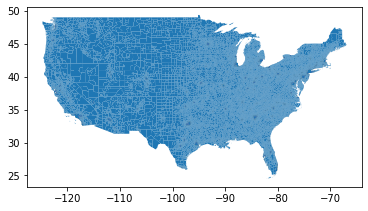

In [12]:
eep_final.plot()

<AxesSubplot:>

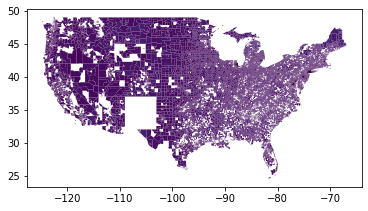

In [6]:
eep_final.plot(column = "energy_burden")

<AxesSubplot:>

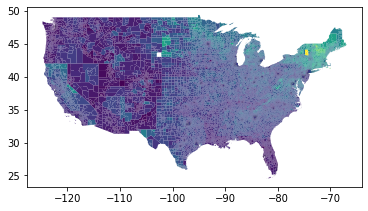

In [7]:
eep_final.plot(column = "avg_shortfall_usd")

<AxesSubplot:>

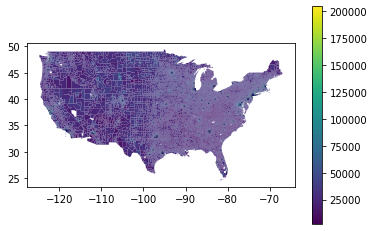

In [8]:
eep_final.plot(column = "median_income", legend = True)